# SPIKING DATA GENERATOR

## Generates the files (output spikes) necessary to train the readouts.

In [14]:
import sys
from BEE import *

In [15]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

# plt.rcParams['figure.figsize'] = 5, 10 # redefines the figure's default size

import numpy

import save_load_file as slf

In [16]:
#
# Controls if the results are saved to a file
#

save2file = True

# Initialization and functions necessary to all the liquids

In [17]:
sim_set = "square" # basically is the name of the folder (shape) where the data is read/saved
base_dir = "BaxterArm_VREP_simulation_data"

In [18]:
# This data must follow what was used to generate the trajectories
# or the arm model will behave differently!

# Total time spent during the movement (in seconds)
MT = 2.0

# Simulation time step (in seconds)
time_step = 2/1000.0

total_steps = int(MT/time_step)

In [19]:
# S0, S1, E1 and W1 are the Baxter's joint names
# Four joints => four input variables
Number_of_input_variables=4 # defines how the liquid is going to be divided to receive the inputs

In [20]:
#
# Number of neurons at each input layer (defines the INPUT resolution of the system)
#
# >>>>>>>>> It MUST be smaller or equal to (NofN/Number_of_input_variables) <<<<<<<<<<<
#
Ninput = 150

In [21]:
# Loads the joint angles saved by the V-REP simulated BAXTER
original_joints=numpy.zeros((0,4)) #creates an empty array with the right shape...

temp=numpy.load(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+".npy")
original_joints=numpy.concatenate((original_joints,temp[:1000]))

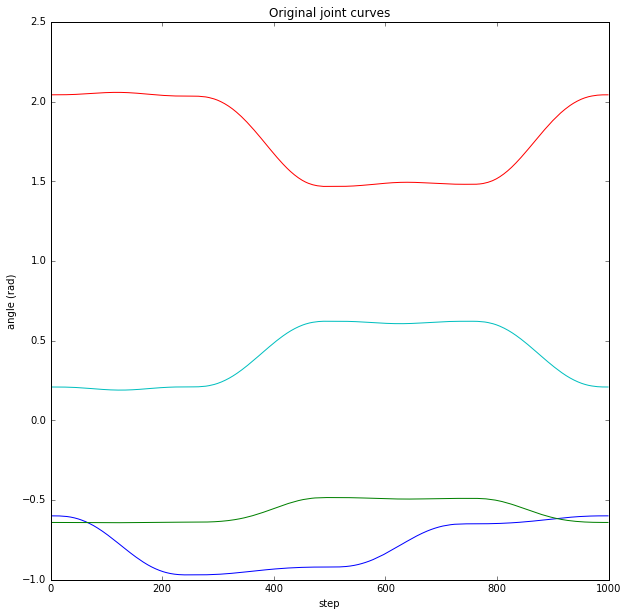

In [22]:
plt.figure(figsize=(10,10))
plt.plot(original_joints)
plt.title("Original joint curves")
plt.ylabel("angle (rad)")
plt.xlabel("step")
plt.xlim(0,1000)
plt.show()

In [23]:
def generates_input_spikes_lsm(number_of_steps=total_steps, \
                               neurons_per_layer=Ninput, \
                               number_of_joints=Number_of_input_variables, \
                               joints_all=numpy.copy(original_joints)):
        
    
    # Creates the Ninput possible discrete values of angle for each joint
    # Because the normalisation all joints are ALWAYS between -1 and 1
    joints_values_normalized=numpy.empty((neurons_per_layer,number_of_joints))
    for ji in range(number_of_joints):
        joints_values_normalized[:,ji]=numpy.linspace(-1,1,neurons_per_layer)
        
    # HERE SEEMS TO BE THE ONLY PLACE I COULD INJECT AN "ANALOG" NOISE INTO THE INPUTS.
    

    # Signal conditioning
    temp_s0=joints_all[:,0]-joints_all[0,0] # Extracts the bias (first value)
    s0_range=(temp_s0.max()-temp_s0.min()) #calculates the range after extracting the bias
    temp_s0=temp_s0/float(s0_range) #normalizes making the biggest value: abs(value)=1

    temp_s1=joints_all[:,1]-joints_all[0,1]
    s1_range=(temp_s1.max()-temp_s1.min())
    temp_s1=temp_s1/float(s1_range)

    temp_e1=joints_all[:,2]-joints_all[0,2]
    e1_range=(temp_e1.max()-temp_e1.min())
    temp_e1=temp_e1/float(e1_range)

    temp_w1=joints_all[:,3]-joints_all[0,3]
    w1_range=(temp_w1.max()-temp_w1.min())
    temp_w1=temp_w1/float(w1_range)


    joints_normalized_idx = numpy.empty((number_of_steps,number_of_joints),dtype=numpy.int)

    for i,jnt in zip(range(number_of_joints),[temp_s0,temp_s1,temp_e1,temp_w1]):
        joints_normalized_idx[:,i]=numpy.array([abs(joints_values_normalized[:,i]-j).argmin() for j in jnt])
        
    joint_s0 = joints_normalized_idx[:,0]
    joint_s1 = joints_normalized_idx[:,1]
    joint_e1 = joints_normalized_idx[:,2]
    joint_w1 = joints_normalized_idx[:,3]

        
    return (joint_s0,joint_s1,joint_e1,joint_w1)

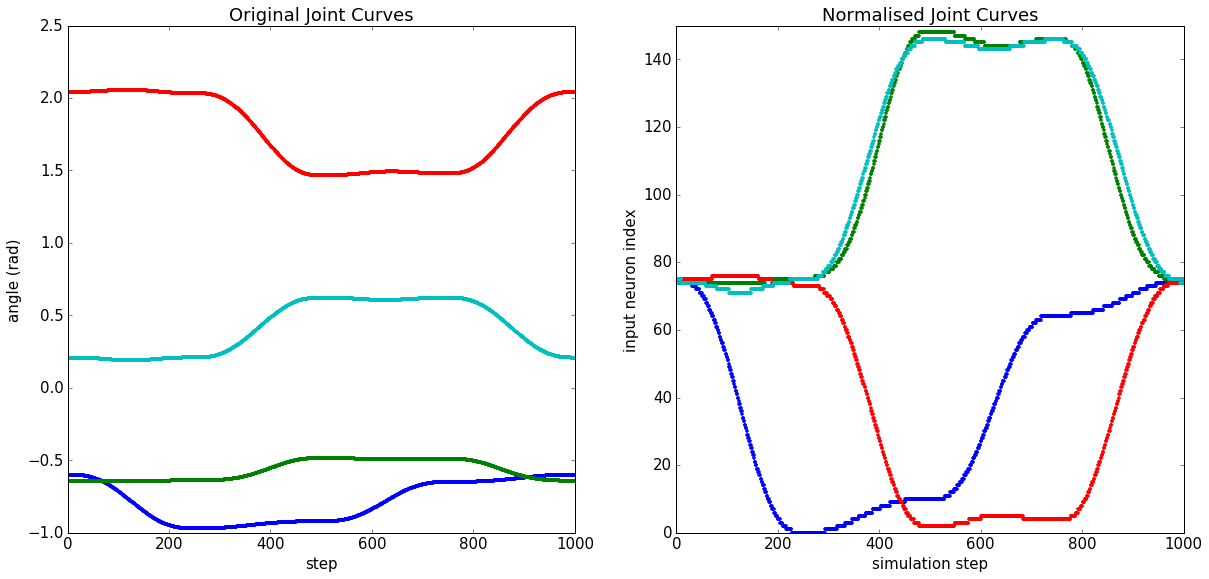

In [24]:
# TESTING THE NEW INPUT CODE

joint_s0,joint_s1,joint_e1,joint_w1 = generates_input_spikes_lsm()

v = joint_s0,joint_s1,joint_e1,joint_w1

font = {'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,20))

plt.subplot(221)
plt.plot(original_joints ,'.')
plt.title("Original Joint Curves")
plt.ylabel("angle (rad)")
plt.xlabel("step")

plt.subplot(222)
for vi,ji in zip(v,['s0','s1','e1','w1']):
    plt.plot(vi,'.', label="joint "+ji)
plt.title("Normalised Joint Curves")
plt.ylabel("input neuron index")
plt.xlabel("simulation step")
plt.ylim(0,Ninput)
# if save2file:
#     plt.savefig(base_dir+"/"+sim_set+"/example_input_norm.pdf", bbox_inches='tight',pad_inches=.1)
plt.show()

# Configuring the liquid:

In [25]:
# 
# Defines how many liquids
# 
number_of_liquids = 5



liqseeds = []
for i in range(number_of_liquids):
    liqseeds.append(numpy.array(numpy.random.randint(0,10000,6),dtype=numpy.uint32))
    
#
# Comment the next line to generate NEW seeds
#
liqseeds=slf.load_from_file_gz(base_dir+"/"+sim_set+"/"+"liqseeds.gzpickle")    

In [26]:
# Uncomment the next two lines to save the NEW seeds:
# if save2file:
#     slf.save_to_file_gz(liqseeds,"./"+base_dir+"/"+sim_set+"/"+"liqseeds.gzpickle")

for i in range(number_of_liquids):
    print "Liquid %d:" % i, liqseeds[i]

Liquid 0: [8504 6373 6528 9820 4728 5408]
Liquid 1: [6878 1704 9127 4863 8948 3511]
Liquid 2: [ 214 9852 3943 8654 8283 5606]
Liquid 3: [4730  341 4093 7541  811  467]
Liquid 4: [3202  913 4191 4309 9239 8001]


# Simulations with different liquids start here!
## It needs to be repeated from lsm_i = 0 up to (number_of_liquids-1)

In [56]:
#
# Here the liquid index is defined
#
# REMEMBER: it goes from ZERO to number_of_liquids-1

lsm_i = 4


#
# Liquid's shape
#

# Liquid's shape
net_shape = numpy.array([20,5,6])

# Random seeds:
# // RANDOM-1: Noisy offset currents / resets
# // RANDOM-2: Selection of the inhibitory and excitatory neurons
# // RANDOM-3: Internal connections of the liquid
RANDOM_1=liqseeds[lsm_i][1]
RANDOM_2=liqseeds[lsm_i][2]
RANDOM_3=liqseeds[lsm_i][3]
#DEBUG!
# RANDOM_4=8337
# RANDOM_0=5751

RANDOM_input=liqseeds[lsm_i][5] # input gaussian noise

input_noise_std = 1 # Standard deviation of the input gaussian noise

# Neuron parameters
taum=0.03 # membrane time constant
cm=3e-08 # membrane capacitance
taue=0.003 # excitatory synapse time constant
taui=0.006 # inhibitory synapse time constant


# Parameters paper Joshi/Maass
membrane_rand=[13.5E-3,14.9E-3] # mean value 13.7E-3, uniform distribution, max value below threshold (15mV).
current_rand=[13.5E-09, 14.5E-09] # mean value 14E-9, uniform distribution.
#
#
noisy_current_rand=1E-27 # normal distribution, mean zero.
#
#

factor=2*10.0

SpkLiq_vresets_rand=[13.8E-3,13.8E-3*(1+1/factor)] # the membrane reset values are drawn from a uniform distribution


lbd_value = 1.2 

# Controls if the neurons are connected to each other (basically ignores the distance based connection probability)
disconnected = False

parameter_list=\
[[[0.1  ,  0.32 ,  0.144,  0.06 ,  -47.  ,  0.8],\
  [0.4  ,  0.25 ,  0.7  ,  0.02 ,  -47  ,  0.8]],\
 [[0.2  ,  0.05 ,  0.125,  1.2  ,  150  ,  0.8],\
  [0.3  ,  0.5  ,  1.1  ,  0.05 ,  70  ,  1.5]]]


input_gain=105. # gain used for the input neurons
w_SD = 3.0 # input neurons standard deviation


#
# END OF THE SETUP - everything that should change between liquids is expressed above...
#


#
# This first initialization of the simulator is only used to generate the liquid structure's data
#

# Resets the simulator
BEE_free()

tstp = time_step

seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
# // RANDOM-0: Membrane initial potentials
# // RANDOM-1: Noisy offset currents / resets
# // RANDOM-2: Selection of the inhibitory and excitatory neurons
# // RANDOM-3: Internal connections of the liquid
# // RANDOM-4: Noisy corrents
seeds[1] = RANDOM_1
seeds[2] = RANDOM_2
seeds[3] = RANDOM_3

input_noise_seed = RANDOM_input

if not BEE_initialized():
    initialize_sim(my_net_shape = net_shape, \
                   my_lbd_value = lbd_value, \
                   my_seeds=seeds, \
                   SpkLiq_step=time_step,\
                   SpkLiq_threads_N = 5,\
                   SpkLiq_vresets = SpkLiq_vresets_rand,\
                   SpkLiq_membrane_rand=membrane_rand,\
                   SpkLiq_current_rand=current_rand,\
                   SpkLiq_taum=taum, SpkLiq_cm=cm, SpkLiq_taue=taue, SpkLiq_taui=taui, \
                   SpkLiq_noisy_current_rand=noisy_current_rand)
    

if parameter_list!=[]:
    change_parameters(parameter_list)

if BEE_initialized() and (not BEE_connected()):
    generate_connections()

#
# Cancels the connections (if disconnected==True), but keeps the parameters
#
if disconnected:
    BEE_writes_SpkLiq_inh_connections(0)
    BEE_writes_SpkLiq_exc_connections(0)

if BEE_initialized() and (not BEE_connected()):
    process_connections()

NofN,NoINHN,NoEXCN,NoINHC,NoEXCC=output_stats(stats=0)

# Normally the BEE simulator does NOT updates neurons that have no connections to other neurons.
# The neurons without connections are marked in a special array that can be read from the
# Python function output_connected(NofN).
# Every time the simulator goes through one step it checks if the neurons is marked as connected before
# updating its state variables.

# Disconnects all the neurons (nothing will generate spikes anymore)
# control_connected(numpy.zeros(NofN,dtype=numpy.int32))

# Forces the simulator to calculate the values for all neurons (even the unconnected ones)
# This is important during the tests without connections
control_connected(numpy.ones(NofN,dtype=numpy.int32))


#
# Input converter
# 

# This information is used to define the neurons receiving inputs (excitatory neurons):
inhibitory_index_L = output_inh_indices(NoINHN)
inhibitory_index_L.shape

inhibitory_index_L=[] # input signals through all neurons (not only excitatory ones)

#
# Input pattern generation
# 

Number_of_neurons_lsm = NofN
Number_of_input_layers = Number_of_input_variables
Number_of_neurons_inputs = Ninput



# 
# 2D Gaussian generation
#

#
# Generates the connection pattern used. In the case below it's a gaussian 
# distributed one based on the connection weights.
#

inputs_indices = [] #inputs_indices[input_variable][ni]
inputs_weights = [] #inputs_weights[input_variable][ni]


def gaussian(lamb,n,nt):
    '''
    Generates a gaussian centered at 'n'
    '''
    return input_gain*numpy.exp(-((nt-n)**2)/(2*(lamb)**2)) #No energy normalization

weight_func = gaussian


liquid_input_layer_size = int(Number_of_neurons_lsm/float(Number_of_input_layers))

# Goes through the liquid to generate the proper connections, 
# but dividing the liquid into the same number of input layers.
# Each input layer only connects to its own slice of the liquid.

centre_positions=numpy.linspace(0,liquid_input_layer_size-1,num=Number_of_neurons_inputs).astype(dtype=numpy.int)

for inp in range(Number_of_input_layers): #goes through the input layers
    temp_i=[]
    temp_w=[]        
    for i,ic in zip(range(inp*Number_of_neurons_inputs,Number_of_neurons_inputs*(inp+1)),\
                    range(Number_of_neurons_inputs)): #goes through the input neurons
        temp_i2 = []
        temp_w2 = []
        for j,ji in zip(range(inp*liquid_input_layer_size,liquid_input_layer_size*(inp+1)),\
                        range(liquid_input_layer_size)):
            if j not in inhibitory_index_L:
                centre_position=centre_positions[ic]
                temp_weight=weight_func(w_SD,centre_position,ji)             
                if temp_weight>0: #guaranties only real spikes will be injected, saving cpu time
                    temp_w2.append(temp_weight) # in nA
                    temp_i2.append(j) # i=>input's neuron; j=>liquid's neuron                                        
        temp_i.append(temp_i2)
        temp_w.append(temp_w2)
    inputs_indices.append(temp_i)
    inputs_weights.append(temp_w)

# This is the readout training

In [57]:
def run_simulations_training(sim_num,input_noise=0):
    
    pos_i, run_i, input_spikes, folder_names, lsm_i = sim_num

    sim_set,base_dir = folder_names
    
    input_spikes_s0,input_spikes_s1,input_spikes_e1,input_spikes_w1 = input_spikes
    
    input_rs = numpy.random.RandomState(seed=input_noise_seed) # Used for the input noise only.

    #
    # Initializing the simulation...
    #
        
    seeds=numpy.array(numpy.random.randint(0,10000,5),dtype=numpy.uint32)
    # // RANDOM-0: Membrane initial potentials
    # // RANDOM-1: Noisy offset currents / resets <<<<<<<<
    # // RANDOM-2: Selection of the inhibitory and excitatory neurons <<<<<<<<
    # // RANDOM-3: Internal connections of the liquid <<<<<<<<
    # // RANDOM-4: Noisy corrents
    seeds[1] = RANDOM_1
    seeds[2] = RANDOM_2
    seeds[3] = RANDOM_3        

    liquid_soft_reset(seeds) # Resets the simulator
        
    
    number_of_steps = total_steps

    
    # Initialize the arrays with the simulated values
    # and saves the values for t=0s
    spikes = []
    ti=0
    
    first_step = True #avoids noise into the first step
    
    # Runs the simulation going step-by-step
    # All the input variables are always used (no delay)
    for s0,s1,e1,w1 in zip(input_spikes_s0,input_spikes_s1,input_spikes_e1,input_spikes_w1):

        if (input_noise>0) and (not first_step):
            
            int_noise = input_rs.normal(loc=0,\
                                        scale=input_noise_std,\
                                        size=Number_of_input_variables).astype(dtype=numpy.int)
        
            [s0_lsm, s1_lsm, e1_lsm, w1_lsm]=[s0, s1, e1, w1]
            
            # Here I'm inserting noise into ALL inputs.
            if (Ninput>(s0_lsm+int_noise[0])>=0): #this test verifies if it's a valid input index
                s0_lsm+=int_noise[0]
                
            if (Ninput>(s1_lsm+int_noise[1])>=0):
                s1_lsm+=int_noise[1]

            if (Ninput>(e1_lsm+int_noise[2])>=0):
                e1_lsm+=int_noise[2]

            if (Ninput>(w1_lsm+int_noise[3])>=0):
                w1_lsm+=int_noise[3]

            input_spikes = [s0_lsm, s1_lsm, e1_lsm, w1_lsm]

        else: # no input noise
            first_step = False # guarantees the first step is free of noise.
            input_spikes = [s0, s1, e1, w1]

        # Generates the input spikes (and weights) based on the connection pattern defined.
        # The '[:,1]' is used to pass the post-synaptic (second column) neuron index
        exc_inputs = numpy.concatenate([numpy.array(inputs_indices[input_variable][ni]) for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
        inh_inputs = []
        exc_weights =  numpy.concatenate([numpy.array(inputs_weights[input_variable][ni]) for input_variable,ni in zip(range(len(input_spikes)),input_spikes)])
        inh_weights = []

        # Here the simulator is receiving the input spikes:
        updates_sim(exc_inputs, inh_inputs, exc_weights*1E-9, inh_weights, len(exc_inputs),0)

        # Appends to the output
        spikes.append([ti,reads_spikes(NofN)])
        ti+=time_step        
    
#     filename = "/Joint_Angles"+str(pos_i)+"_LSM_"+str(lsm_i)+"_"+str(run_i)+".gzpickle"
    filename = "/Joint_Angles"+str(pos_i)+"_LSM_"+str(lsm_i)+"_"+str(run_i)+"SMALL_NOISE.gzpickle"    
    
    if save2file:
        slf.save_to_file_gz(spikes,"./"+base_dir+"/"+sim_set+filename)

In [58]:
%%time

total_trials = 100

#
# DON'T FORGET THE INPUT NOISE!!!!!!
#
input_spikes = generates_input_spikes_lsm()  
for sim_num in [(0,i,input_spikes,(sim_set,base_dir),lsm_i) for i in range(1,total_trials+1)]:

    input_noise_seed = numpy.random.randint(0,10000) # Guarantees the input noise is random.

# Uncomment the next line to be able to run the simulations!
    run_simulations_training(sim_num,input_noise=1)

CPU times: user 43.1 s, sys: 39.3 s, total: 1min 22s
Wall time: 55.1 s


In [59]:
total_steps = 100

lsm_i=4
pos_i=0
run_i=total_steps
# filename = "/Joint_Angles"+str(pos_i)+"_LSM_"+str(lsm_i)+"_"+str(run_i)+".gzpickle"
filename = "/Joint_Angles"+str(pos_i)+"_LSM_"+str(lsm_i)+"_"+str(run_i)+"SMALL_NOISE.gzpickle"    
print filename
spikes_sim=slf.load_from_file_gz("./"+base_dir+"/"+sim_set+"/"+filename)
spikes = [i[1] for i in spikes_sim]
t = [i[0] for i in spikes_sim]

/Joint_Angles0_LSM_4_100SMALL_NOISE.gzpickle


In [60]:
spikes[:5]

[array([], dtype=int32),
 array([ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  83,
        219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
        368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
        381, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530], dtype=int32),
 array([ 68,  69, 218, 232, 367, 383, 517, 518, 519, 531], dtype=int32),
 array([ 51,  57,  66,  67,  74,  77,  82,  84,  96, 104, 121, 124, 125,
        130, 140, 146, 151, 155, 169, 175, 179, 193, 201, 210, 211, 217,
        219, 228, 260, 269, 272, 275, 279, 290, 298, 341, 342, 350, 351,
        358, 360, 376, 382, 388, 402, 408, 431, 445, 448, 455, 468, 473,
        474, 488, 490, 494, 496, 505, 507, 516, 526, 541, 547, 572, 580], dtype=int32),
 array([ 48,  70,  71,  72,  73,  75,  76,  78,  79,  80,  81, 111, 149,
        168, 213, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231,
        252, 368, 369, 370, 371, 372, 373, 374, 375, 377, 378, 379, 380,
 

In [61]:
total_spikes = len(numpy.concatenate(spikes))
print "Total number of spikes:",total_spikes

Total number of spikes: 108812


In [62]:
number_of_steps = total_steps
print "Total Number of Spikes Generated:%d\nTotal Number of Neurons:%d\nFigure Spike Density(%%):%f"%(total_spikes,NofN*len(spikes),100*total_spikes/float(NofN*len(spikes)))

Total Number of Spikes Generated:108812
Total Number of Neurons:600000
Figure Spike Density(%):18.135333


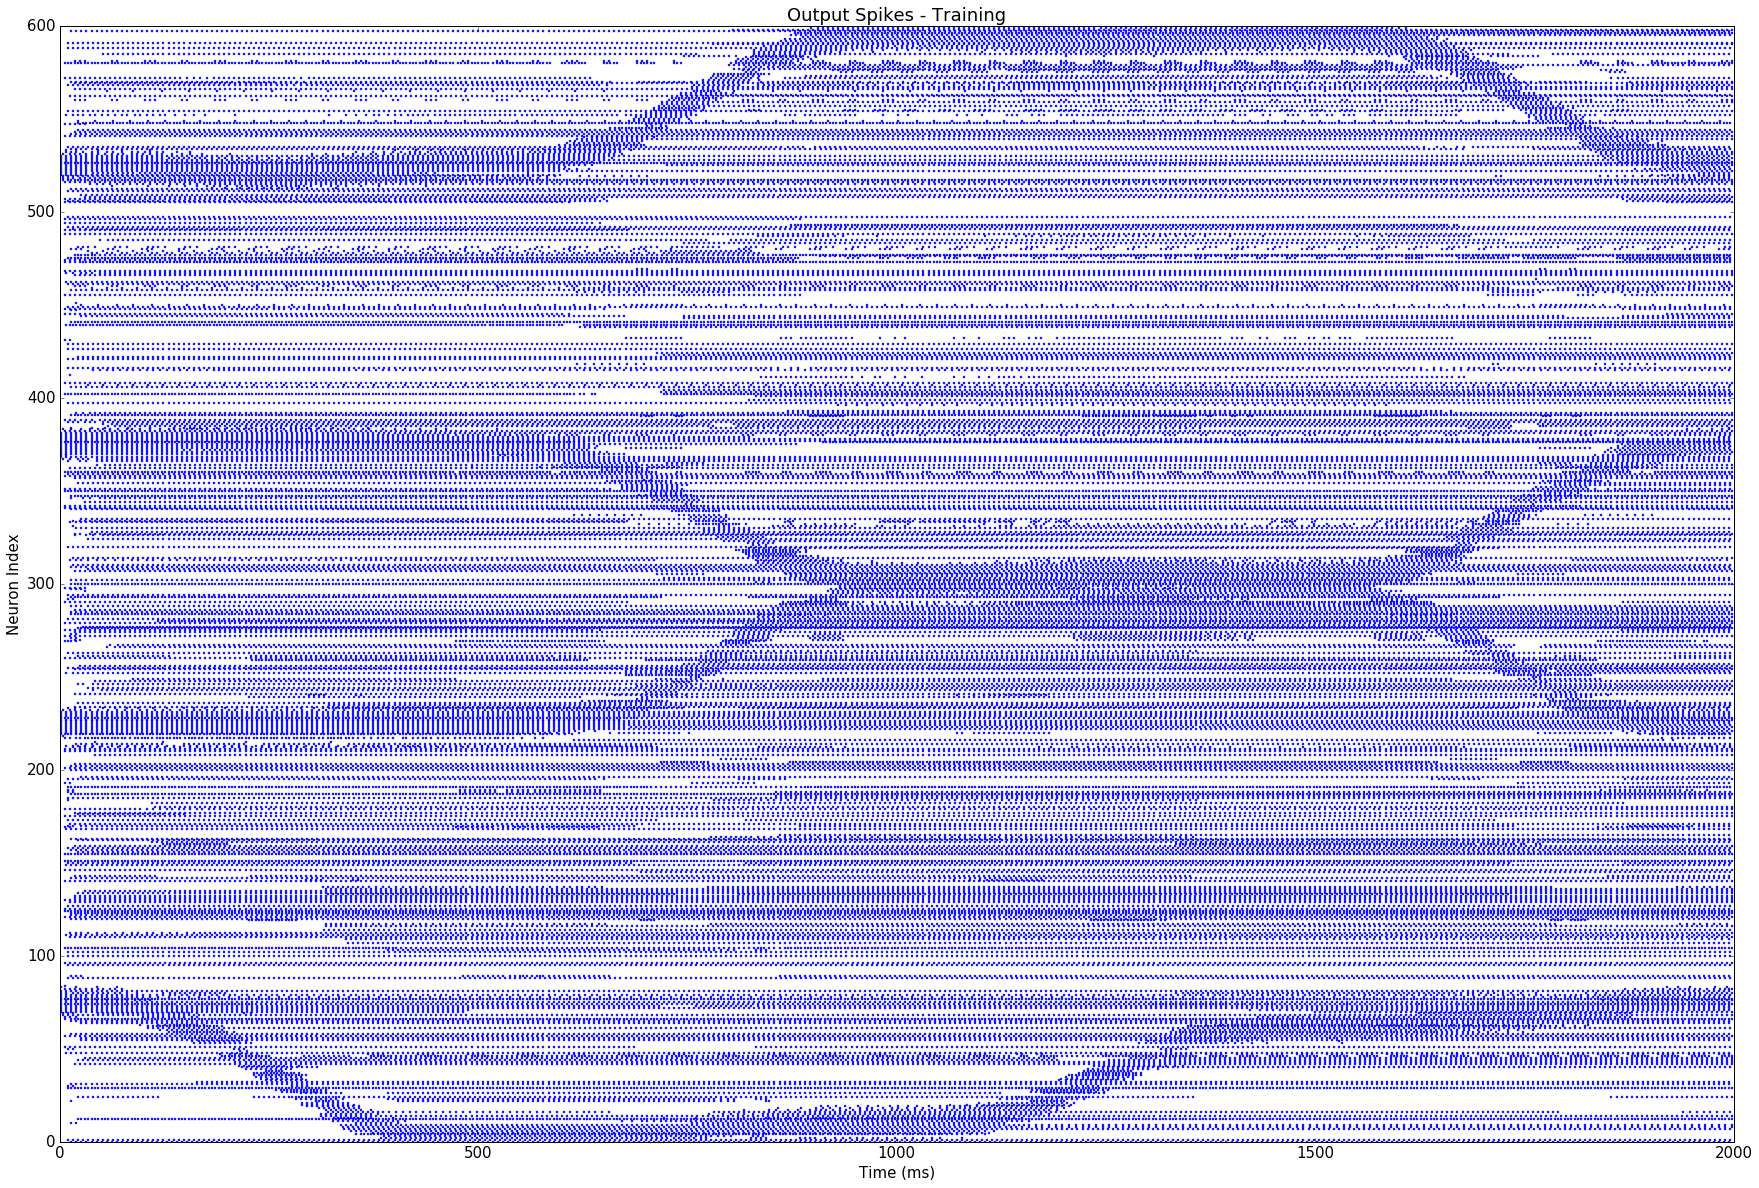

In [63]:
x_plot = numpy.array([t[ti] for i,ti in zip(spikes,xrange(len(spikes))) for j in i])
y_plot = numpy.array([j for i,ti in zip(spikes,xrange(len(spikes))) for j in i])

plt.figure(figsize=(30,20))
plt.plot(x_plot*1000,y_plot,'.', markersize=4)#, markevery=100);
# plt.plot(y_plot,'.', markersize=1)#, markevery=100);
# plt.plot(x_plot*1000,y_plot,'.');
# plt.xlim(t[0]*1000-1,t[-1]*1000+2);
plt.ylim(0,NofN);
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Index")
plt.title("Output Spikes - Training");
plt.show();

In [50]:
import membrane_lowpass_md
membrane_lowpass = membrane_lowpass_md.membrane_lowpass

membrane_time_constant = 30E-3

m_v=membrane_lowpass(NofN,membrane_time_constant) # Initialize the membrane
membrane_values = numpy.zeros((len(spikes),NofN))

ti = 0
for spk_train in spikes:
    if len(spk_train):
        m_v.process_spikes(spk_train,ti*time_step) # Send the spikes to the membrane filter
    membrane_values[ti,:] = m_v.check_values(ti*time_step) # Reads the values of the membranes
    ti+=1

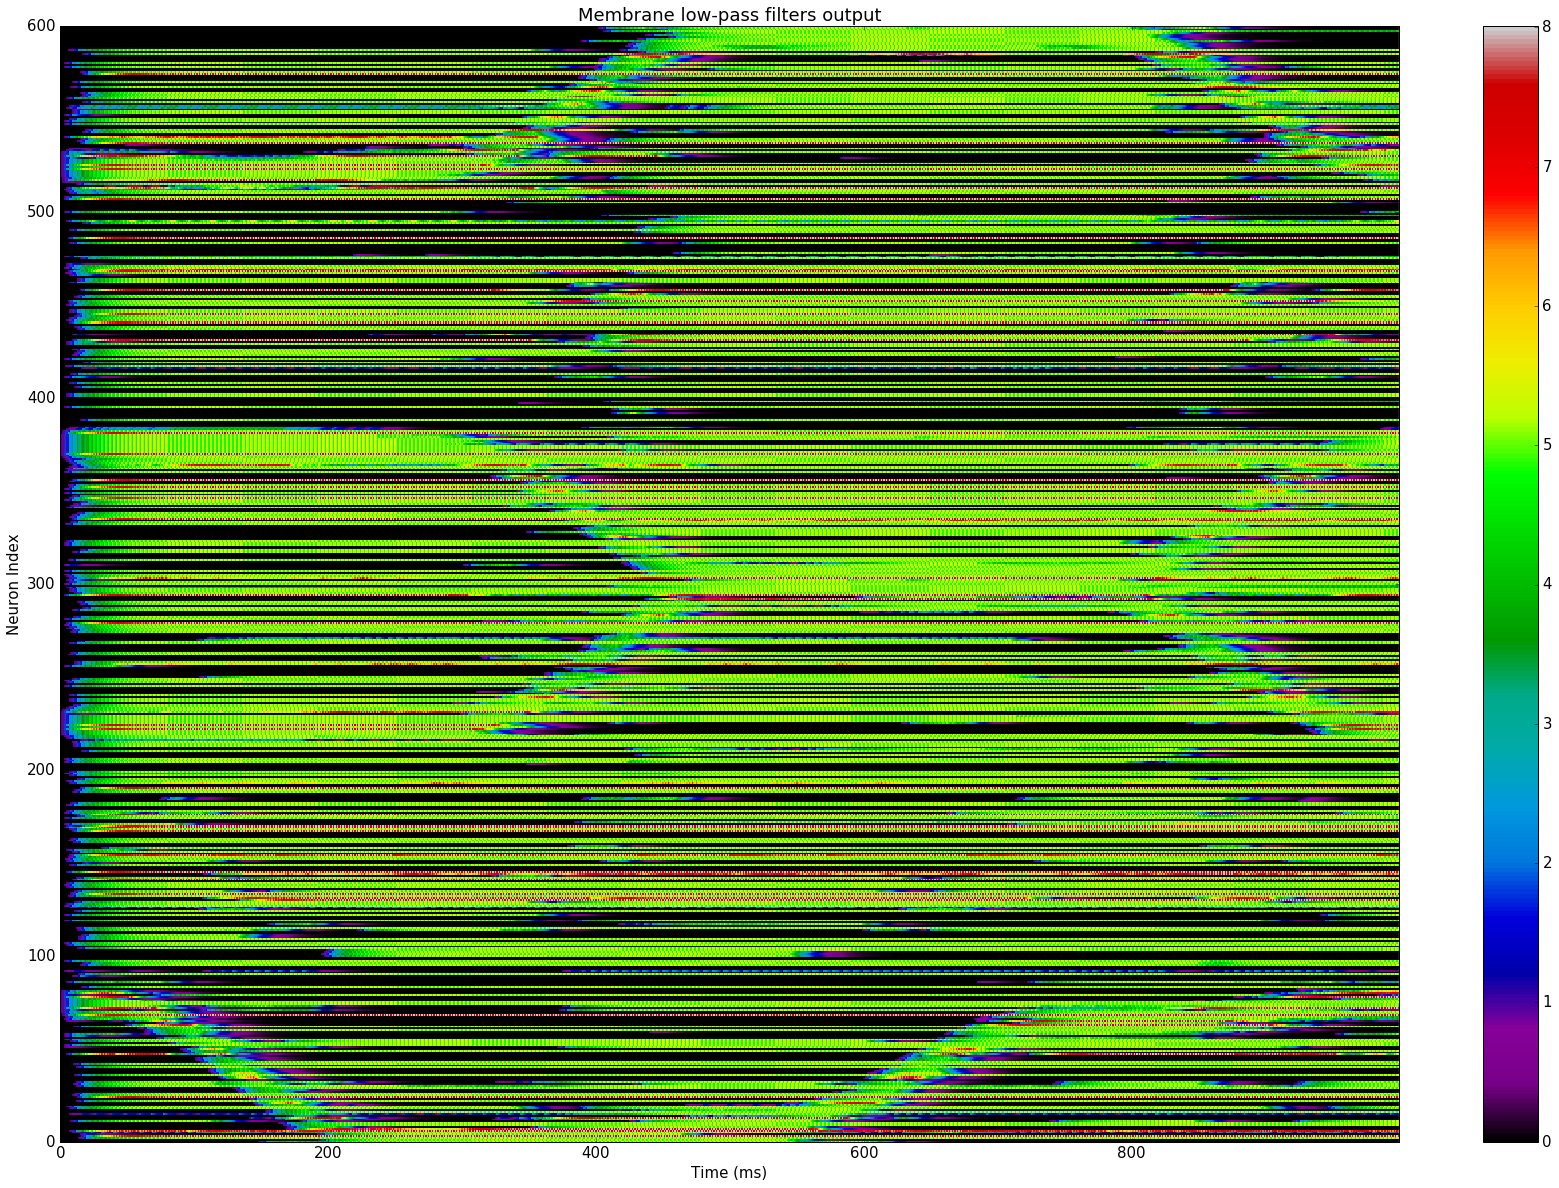

In [51]:
plt.figure(figsize =(30,20))
plt.imshow(membrane_values.T, origin='lower', aspect='auto',interpolation='none')
# plt.axis('off')
plt.set_cmap('spectral')
plt.colorbar()
plt.xlabel("Time (ms)")
# plt.xticks(range(0,len(spikes)+100,100),range(0,len(spikes)*2+200,200))
plt.ylabel("Neuron Index")
plt.ylim(0,NofN)
plt.title("Membrane low-pass filters output")

# plt.xlim(0,20)
plt.show()